In [654]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit, fit_report
import pandas as pd
from scipy.constants import N_A
import seaborn as sns

In [655]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [673]:
def model_S_monospecific(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def model_R_monospecific(t, z, Ainit, rtot, kon, koff):
    k = Ainit*kon
    Atot = well_size*N_A*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] 
    Ag = rtot - z[0] - 2*z[1]
    target_effective_conc1 =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume)
    k2 = target_effective_conc1*kon

    dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
    dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

    return [dA10, dA11]

def solve_ode(x, params):
     
    solution_vals = np.zeros_like(x)

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']

    for j, val in enumerate(x):
            A0 = 1e-9*val
            z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon,
                                                                                            koff, k2))
        
            A10 = z.y[0]
            A11 = z.y[1]
            A10_STST = A10[-1]
            A11_STST = A11[-1]

            Ag = (rtot - A10_STST - 2*A11_STST)/rtot
        
            solution_vals[j] = Ag
    
    return np.asarray(solution_vals)

def objective(params, x, data):
    ndata =  len(data)
    resid = np.zeros_like(data)

    sol = solve_ode(x, params)
    for i in range(ndata):
        resid[i] = data[i] - sol[i]
    
    return resid

def calc_total_ab(x, params_list):

    solution_vals = np.zeros_like(x)
    params1 = params_list[0]
    params2 = params_list[1]

    rtot1 = params1[f'rtot']
    kon1 = params1[f'kon']
    k21 = params1[f'k2']
    koff1 = params1[f'koff']

    rtot2 = params2[f'rtot']
    kon2 = params2[f'kon']
    k22 = params2[f'k2']
    koff2 = params2[f'koff']
    
    for j, val in enumerate(x):
         A0 = 1e-9*val
         Atot = well_size*N_A*A0/Target_cell_number
         z = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot1, kon1,
                                                                                            koff1, k21))
         w = solve_ivp(model_S_monospecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot2, kon2,
                                                                                            koff2, k22))
         
         P_A10 = z.y[0]
         P_A11 = z.y[1]
         C_A10 = w.y[0]
         C_A11 = w.y[1]
         P_A10_STST = P_A10[-1]
         P_A11_STST = P_A11[-1]
         C_A10_STST = C_A10[-1]
         C_A11_STST = C_A11[-1]

         Ab = (P_A10_STST + C_A10_STST + (P_A11_STST + C_A11_STST))/(rtot1 + rtot2)
         solution_vals[j] = Ab
    
    return solution_vals

In [657]:
df = pd.read_csv('Mazor_monospecific_40_1.csv')
df1 = df[['Dataset_pd1', 'Unnamed: 1']]
x_data_pd1_40 = np.asarray(df1['Dataset_pd1'])
y_data_pd1_40 = np.asarray(df1['Unnamed: 1'])/100

df2 = df[['Dataset_ctla4', 'Unnamed: 3']]
y_data_ctla4_40 = np.asarray(df2['Unnamed: 3'])/100

df3 = df[['Dataset_ab_binding', 'Unnamed: 5']]
y_data_ab_40 = np.asarray(df3['Unnamed: 5'])/100

In [658]:
from scipy.interpolate import interp1d

interp_func_pd1 = interp1d(x_data_pd1_40, y_data_pd1_40)
interp_func_ctla = interp1d(x_data_pd1_40, y_data_ctla4_40)
interp_func_ab = interp1d(x_data_pd1_40, y_data_ab_40)

A0s1 = [1e-11, 1e-10, 1e-9, 1e-8]
A0s = []
vals = np.linspace(1, 9, 10)
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
xdata = np.concatenate((x_data_pd1_40, A0s1))
y_data_pd1 = np.concatenate((y_data_pd1_40, interp_func_pd1(A0s1)))
y_data_ctla4 = np.concatenate((y_data_ctla4_40, interp_func_ctla(A0s1)))
y_data_ab = np.concatenate((y_data_ab_40, interp_func_ab(A0s1)))
data_40_1 = [y_data_pd1, y_data_ctla4, y_data_ab]
data_40_1 = np.array(data_40_1)

In [659]:
fit_params_pd1 = Parameters()
fit_params_ctla4 = Parameters()

fit_params_pd1.add(f'rtot', value = 1e6, min=0)
fit_params_pd1.add(f'kon', value = 1e5, vary=False, min=1e4)
fit_params_pd1.add(f'k2', value = 10, min=0)
fit_params_pd1.add(f'koff', value = 1e-5,  min=0, max = 1e-1)


In [660]:
out = minimize(objective, fit_params_pd1, args=(xdata, data_40_1[0]))
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 52
    # variables        = 3
    chi-square         = 0.03587683
    reduced chi-square = 7.3218e-04
    Akaike info crit   = -372.503185
    Bayesian info crit = -366.649453
[[Variables]]
    rtot:  12768517.9 +/- 283171.267 (2.22%) (init = 1000000)
    kon:   100000 (fixed)
    k2:    172.064300 +/- 3.11063550 (1.81%) (init = 10)
    koff:  0.02548685 +/- 0.00707961 (27.78%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(rtot, koff) = -0.596
    C(rtot, k2)   = 0.277


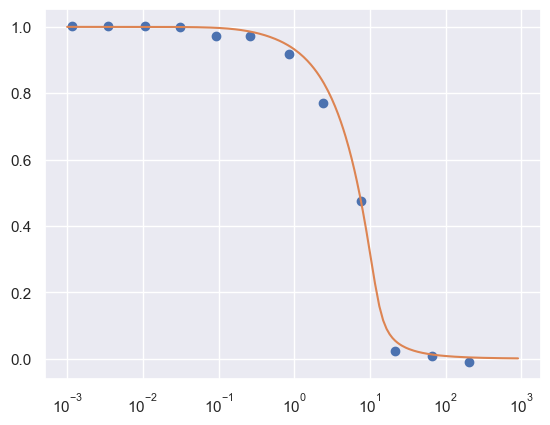

In [661]:
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 50)

sns.set_theme()
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9

y_fit = solve_ode(A0s1, out.params)

plt.plot(x_data_pd1_40, y_data_pd1_40, 'o')
plt.plot(A0s1, y_fit)


plt.xscale('log')
plt.show()

In [671]:
fit_params_ctla4 = Parameters()
fit_params_ctla4.add(f'rtot', value = 1e7/40, vary=False, min=1e2)
fit_params_ctla4.add(f'kon', value = 1e5, min=0,  vary=False)
fit_params_ctla4.add(f'k2', value = 62, min=0)
fit_params_ctla4.add(f'koff', value = 1e-2,  min=0, max=1e-1)
out1 = minimize(objective, fit_params_ctla4, args=(xdata, data_40_1[1]))
report_fit(out1)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 52
    # variables        = 2
    chi-square         = 0.20439882
    reduced chi-square = 0.00408798
    Akaike info crit   = -284.024148
    Bayesian info crit = -280.121661
[[Variables]]
    rtot:  250000 (fixed)
    kon:   100000 (fixed)
    k2:    12.3015368 +/- 2.79657206 (22.73%) (init = 62)
    koff:  0.09999995 +/- 0.00728229 (7.28%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, koff) = 0.830


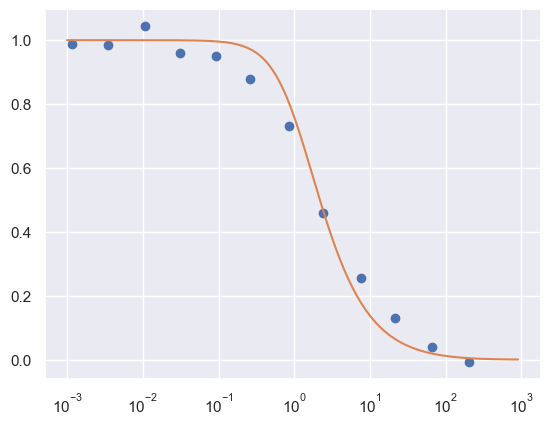

In [672]:
y_fit = solve_ode(A0s1, out1.params)

plt.plot(x_data_pd1_40, y_data_ctla4_40, 'o')
plt.plot(A0s1, y_fit)

plt.xscale('log')
plt.show()

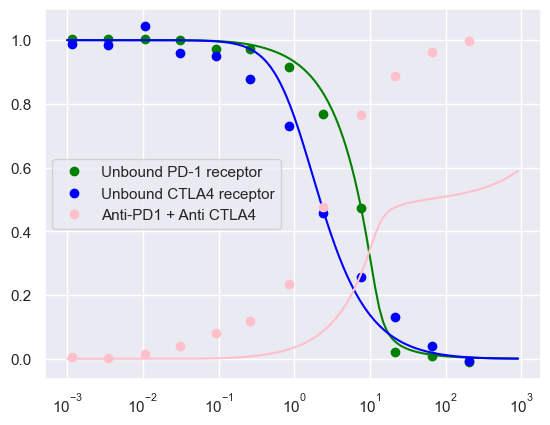

In [674]:
y_fit_pd1 = solve_ode(A0s1, out.params)
y_fit_ctla4 = solve_ode(A0s1, out1.params)
y_fit_ab = calc_total_ab(A0s1, [out.params, out1.params])

exper_data = [y_data_pd1_40, y_data_ctla4_40, y_data_ab_40]
fits = [y_fit_pd1, y_fit_ctla4, y_fit_ab]
colors = ['green', 'blue', 'pink']
labels = ['Unbound PD-1 receptor', 'Unbound CTLA4 receptor', 'Anti-PD1 + Anti CTLA4']

for i, sol in enumerate(fits):
    plt.plot(A0s1, fits[i], color=colors[i])
    plt.plot(x_data_pd1_40, exper_data[i], 'o', color=colors[i], label=labels[i])

plt.legend(loc='best')
plt.xscale('log')
plt.show()